In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [72]:
# actions: hit or stand
ACTION_HIT = 0    #加牌
ACTION_STAND = 1  #停牌
ACTIONS = [ACTION_HIT, ACTION_STAND]

#發牌
def get_card():
    card = np.random.randint(1, 14)
    if card >= 10:
        card = 10
    return card

def card_value(card_id):
    if card_id == 1:
        return 11  
    else:
        return card_id

#莊家策略:小於17點必定加牌
POLICY_DEALER = np.zeros(22)
for i in range(12, 17):
    POLICY_DEALER[i] = ACTION_HIT
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND
    
#玩家策略:
POLICY_PLAYER = np.zeros(22, dtype=np.int)
for i in range(12, 20):
    POLICY_PLAYER[i] = ACTION_HIT
POLICY_PLAYER[20] = ACTION_STAND
POLICY_PLAYER[21] = ACTION_STAND

def target_policy_player(usable_ace_player, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

# for off policy
def behavior_policy_player(usable_ace_player, player_sum, dealer_card):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

In [3]:

def play(policy_player, initial_state=None, initial_action=None):
    # player status
    player_sum = 0
    # whether player uses Ace as 11
    usable_ace_player = False
    # trajectory of player
    player_trajectory = []
    
    # dealer status
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False
    
    if initial_state == None:
        while player_sum < 12:
            # 如果點數和小於12，一定抽牌
            # 因為最大是11，如果加一張一定不會超過，除非拿到ace
            card = get_card()
            player_sum += card_value(card)
            #11拿到ace，把ace視作1
            if player_sum > 21:
                #player_sum一定是22，不是的話報錯
                assert player_sum == 22
                player_sum -= 10
            else:
                #如果有ace，因為card_value，都是視作11
                if card == 1:
                    usable_ace_player = True
                    
        dealer_card1 = get_card()
        dealer_card2 = get_card()
    else:
        usable_ace_player, player_sum, dealer_card1 = initial_state
        dealer_card2 = get_card()
    
    # initial state of the game
    state = [usable_ace_player, player_sum, dealer_card1]
    # initialize dealer's sum
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
    # if the dealer's sum is larger than 21, he must hold two aces.
    if dealer_sum > 21:
        assert dealer_sum == 22
        # use one Ace as 1 rather than 11
        dealer_sum -= 10
    assert dealer_sum <= 21
    assert player_sum <= 21
    
    # Player's Turn，Player先，莊家後
    while True:
        if initial_action is not None:
            action = initial_action
            initial_action = None
        else:
            # get action based on current sum
            action = policy_player(usable_ace_player, player_sum, dealer_card1)
        
        player_trajectory.append(([usable_ace_player,player_sum,dealer_card1],action))
        #一直重複直到不再加牌
        if action == ACTION_STAND:
            break
        else:
            card = get_card()
            #算有幾張可以視做1的ace
            ace_count = int(usable_ace_player)
            player_sum += card_value(card)
            if card == 1:
                ace_count += 1 
            #只要總和大於21，又有可以變作1的ace，就還有救
            if ace_count > 0  and player_sum > 21:
                player_sum -= 10
                ace_count -= 1   
            if player_sum > 21:
                return state, -1, player_trajectory
            
            assert player_sum <= 21
            if ace_count == 1:
                usable_ace_player = True
            else:
                usable_ace_player = False
    # dealer's turn
    while True:
        action = POLICY_DEALER[dealer_sum]
    
        if action == ACTION_STAND:
            break
        else:
            card = get_card()
            #算有幾張可以視做1的ace
            ace_count = int(usable_ace_dealer)
            dealer_sum += card_value(card)
            if card == 1:
                ace_count += 1 
            #只要總和大於21，又有可以變作1的ace，就還有救
            if ace_count > 0  and dealer_sum > 21:
                dealer_sum -= 10
                ace_count -= 1    
            if dealer_sum > 21:
                return state, 1, player_trajectory
            
            assert dealer_sum <= 21
            if ace_count == 1:
                usable_ace_dealer = True
            else:
                usable_ace_dealer = False
            
    #當雙方都加牌完畢且均無超過21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory


In [4]:
# Monte Carlo Sample with On-Policy
def monte_carlo_on_policy(episodes):
    #點數12到21點才有策略，因為小於等於11必定加牌
    #有無可以變成1的ace也會影響策略
    states_usable_ace = np.zeros((10, 10))
    states_usable_ace_count = np.ones((10, 10))
    states_no_usable_ace = np.zeros((10, 10))
    states_no_usable_ace_count = np.ones((10, 10))
    
    for i in tqdm(range(episodes)):
        _ ,reward,player_trajectory = play(target_policy_player)
        for (usable_ace, player_sum, dealer_card), _ in player_trajectory:
            #從0開始
            player_sum -= 12
            dealer_card -= 1
            #所有出現過的
            if usable_ace:
                states_usable_ace_count[player_sum, dealer_card] += 1
                states_usable_ace[player_sum, dealer_card] += reward
            else:
                states_no_usable_ace_count[player_sum, dealer_card] += 1
                states_no_usable_ace[player_sum, dealer_card] += reward
    return states_usable_ace / states_usable_ace_count, states_no_usable_ace / states_no_usable_ace_count
        

In [79]:
def figure_5_1(policy,episodes_1,episodes_2):
    states_usable_ace_1, states_no_usable_ace_1 = policy(episodes_1)
    states_usable_ace_2, states_no_usable_ace_2 = policy(episodes_1)
    states = [states_usable_ace_1,
              states_usable_ace_2,
              states_no_usable_ace_1,
              states_no_usable_ace_2]

    titles = ['Usable Ace, 10000 Episodes',
              'Usable Ace, 500000 Episodes',
              'No Usable Ace, 10000 Episodes',
              'No Usable Ace, 500000 Episodes']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for state, title, axis in zip(states, titles, axes):
        fig = sns.heatmap(np.flipud(state), cmap='YlGnBu', ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)
    
    plt.show()
        


100%|███████████████████████████████████████████████████████████████████████| 500000/500000 [00:13<00:00, 36206.36it/s]


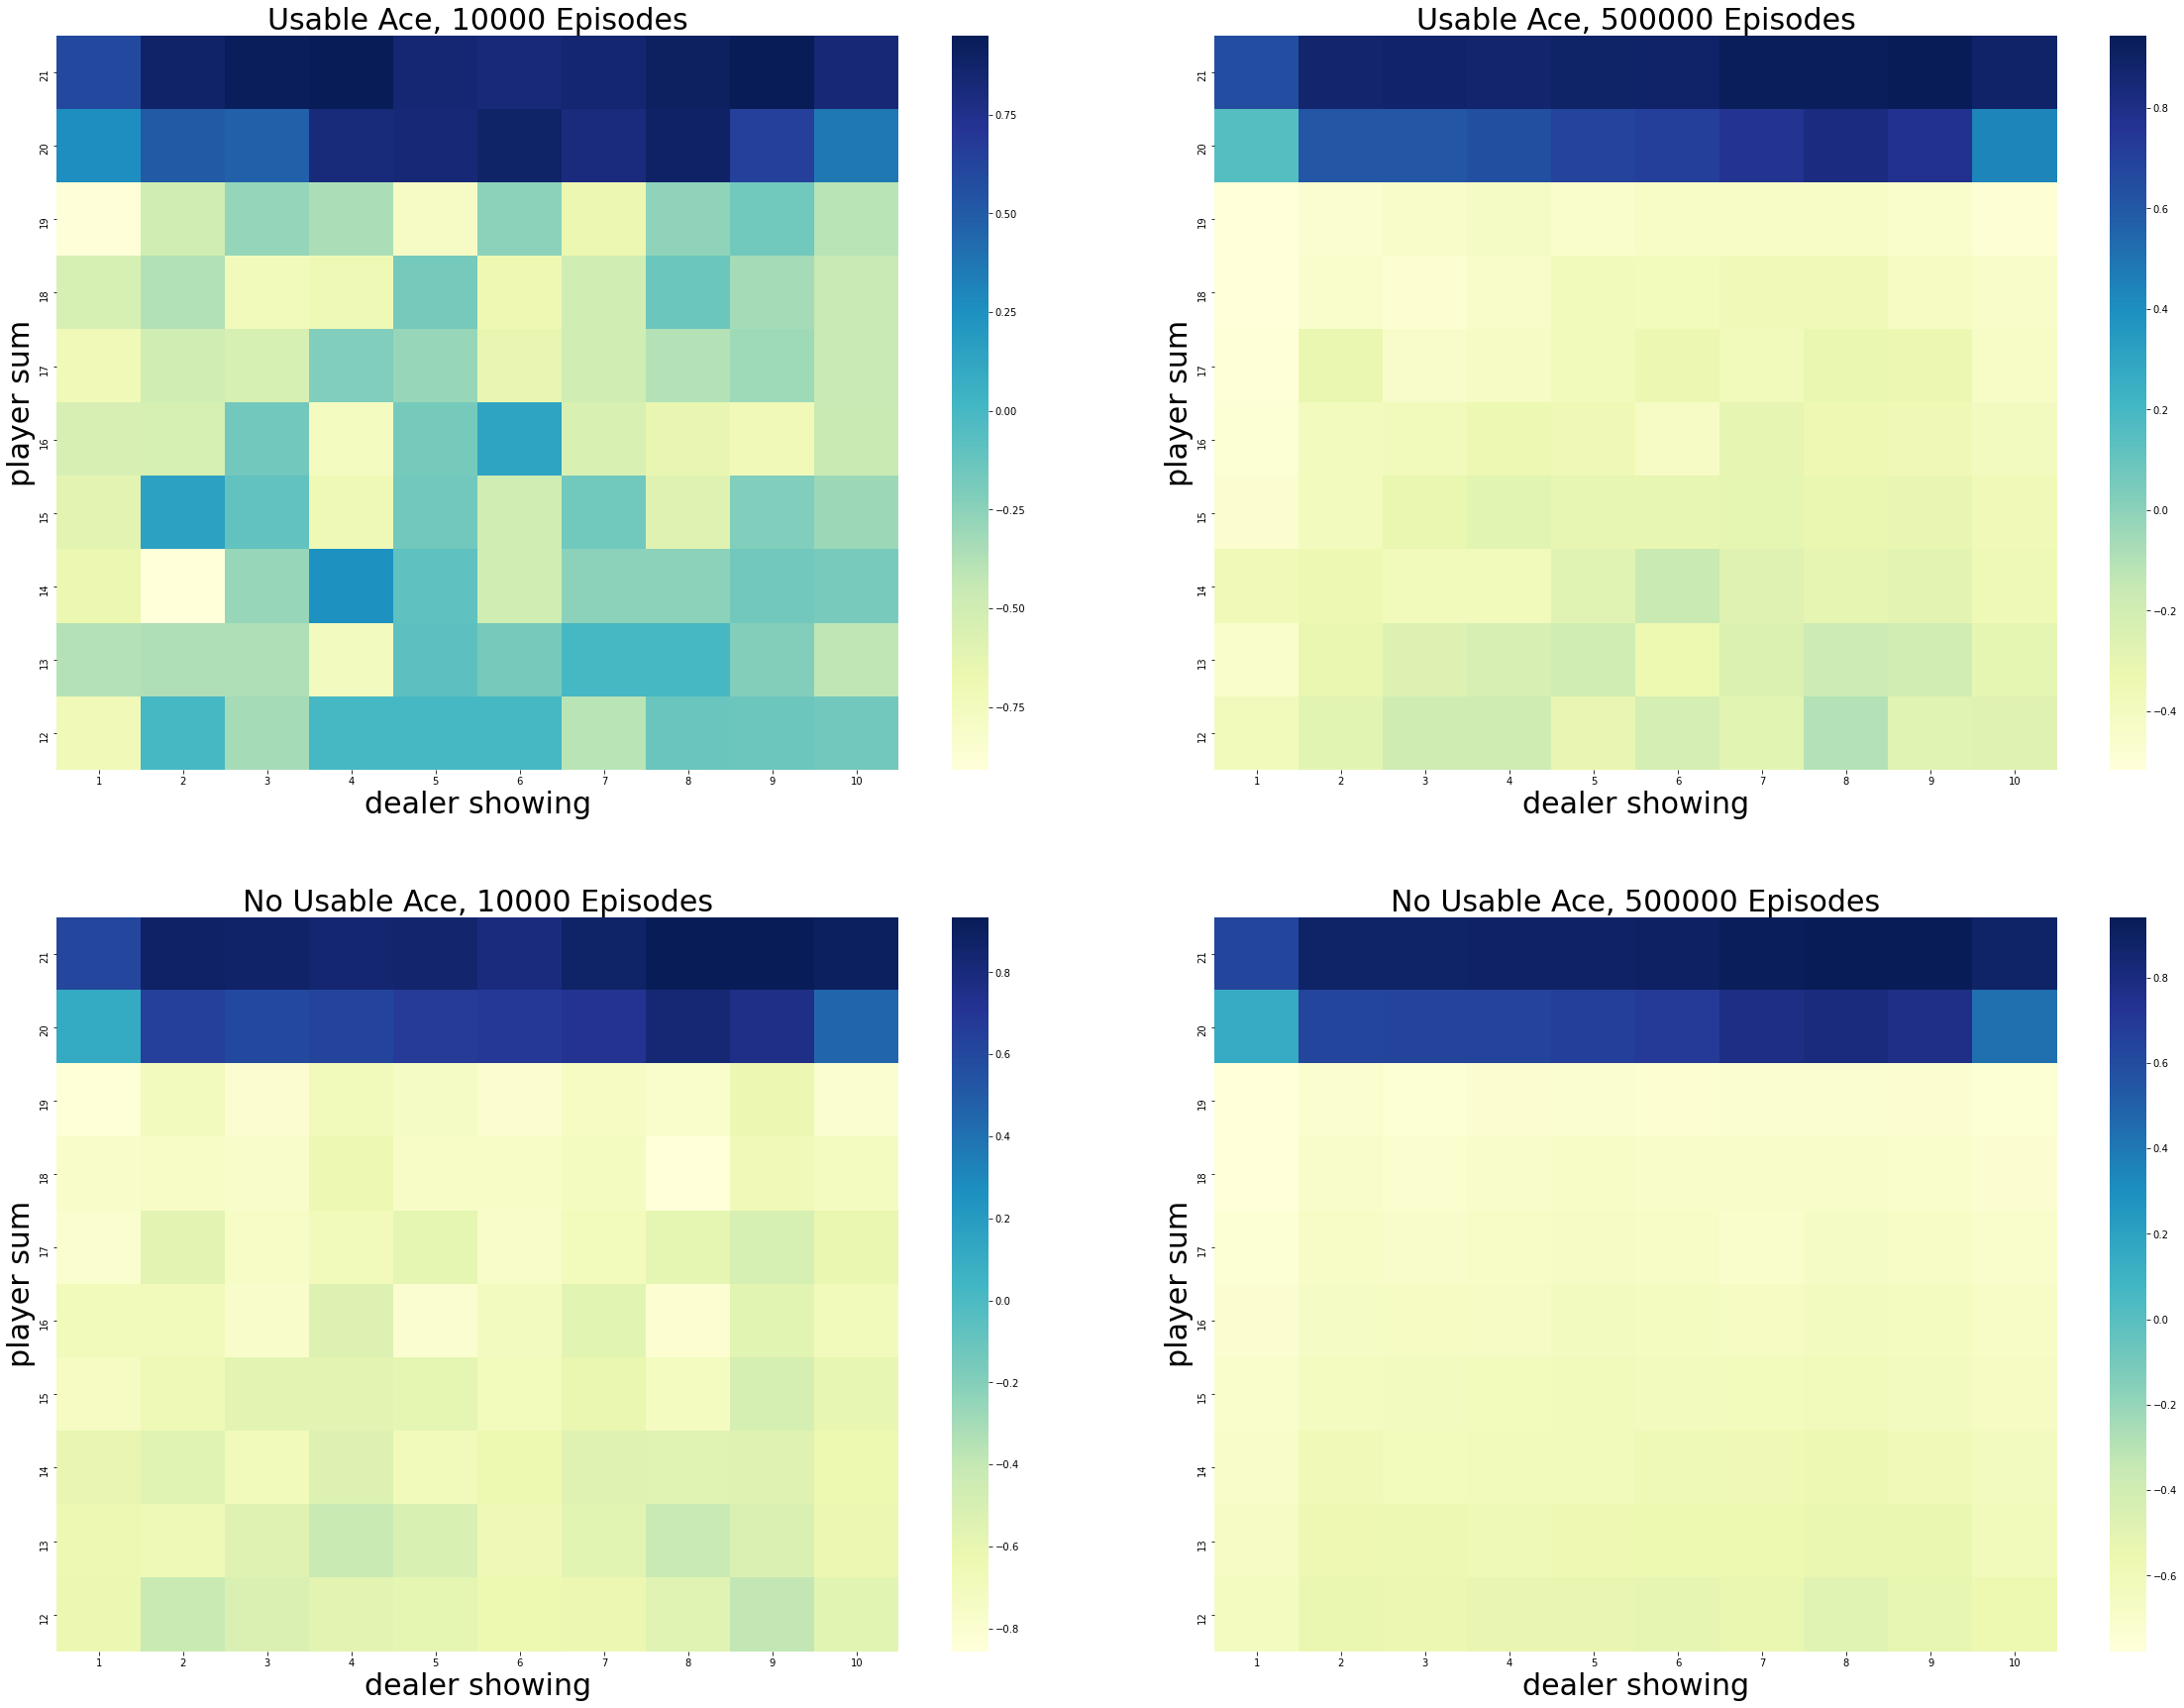

In [6]:
figure_5_1(monte_carlo_on_policy,10000,500000)

In [34]:
# exploring starts:
# 一直隨機選取(s,a)，
# 由隨機的起點玩完一局後，依據所有出現的state更新average(Returns)
# 在接近無限個episode後，照理講value值會收斂

def monte_carlo_exploring_starts(episodes):
    # (playerSum, dealerCard, usableAce, action)
    # (       10,         10,         2,      2)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))
    
    # greedy policy
    def behavior_policy(usable_ace, player_sum, dealer_card):
        usable_ace = int(usable_ace)
        player_sum -= 12
        dealer_card -= 1
        # get argmax of the average returns(s, a)
        # values.shape = (2,)
        values_ = state_action_values[player_sum, dealer_card, usable_ace, :] / \
                  state_action_pair_count[player_sum, dealer_card, usable_ace, :]
        
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])
    
    for i in tqdm(range(episodes)):
        # exploring starts: using a randomly initialized state and action 
        initial_state = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initial_action = np.random.choice(ACTIONS)
        current_policy = behavior_policy 
        if i == 0:
             current_policy = target_policy_player
        _, reward, trajectory = play(current_policy, initial_state, initial_action)
        # set:一個無序不重複的元素集
        first_visit_check = set()
        for (usable_ace, player_sum, dealer_card), action in trajectory:
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            state_action = (usable_ace, player_sum, dealer_card, action)
            if state_action in first_visit_check:
                #避免一局遊戲裡，兩個相同的state重複計算reward
                #雖然我覺得一局遊戲裡，根本不會有兩個相同的state
                continue
            first_visit_check.add(state_action)
            # update values of state-action pairs
            state_action_values[player_sum, dealer_card, usable_ace, action] += reward
            state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1
        
    return state_action_values / state_action_pair_count


In [68]:
def figure_5_2(policy,episodes):
    state_action_values = policy(episodes)

    state_value_no_usable_ace = np.max(state_action_values[:, :, 0, :], axis=-1)
    state_value_usable_ace = np.max(state_action_values[:, :, 1, :], axis=-1)

    # get the optimal policy
    action_no_usable_ace = np.argmax(state_action_values[:, :, 0, :], axis=-1)
    action_usable_ace = np.argmax(state_action_values[:, :, 1, :], axis=-1)

    images = [action_usable_ace,
              state_value_usable_ace,
              action_no_usable_ace,
              state_value_no_usable_ace]

    titles = ['Optimal policy with usable Ace',
              'Optimal value with usable Ace',
              'Optimal policy without usable Ace',
              'Optimal value without usable Ace']

    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    for image, title, axis in zip(images, titles, axes):
        fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel('player sum', fontsize=30)
        fig.set_xlabel('dealer showing', fontsize=30)
        fig.set_title(title, fontsize=30)

    plt.show()


100%|█████████████████████████████████████████████████████████████████████| 2000000/2000000 [02:43<00:00, 12235.77it/s]


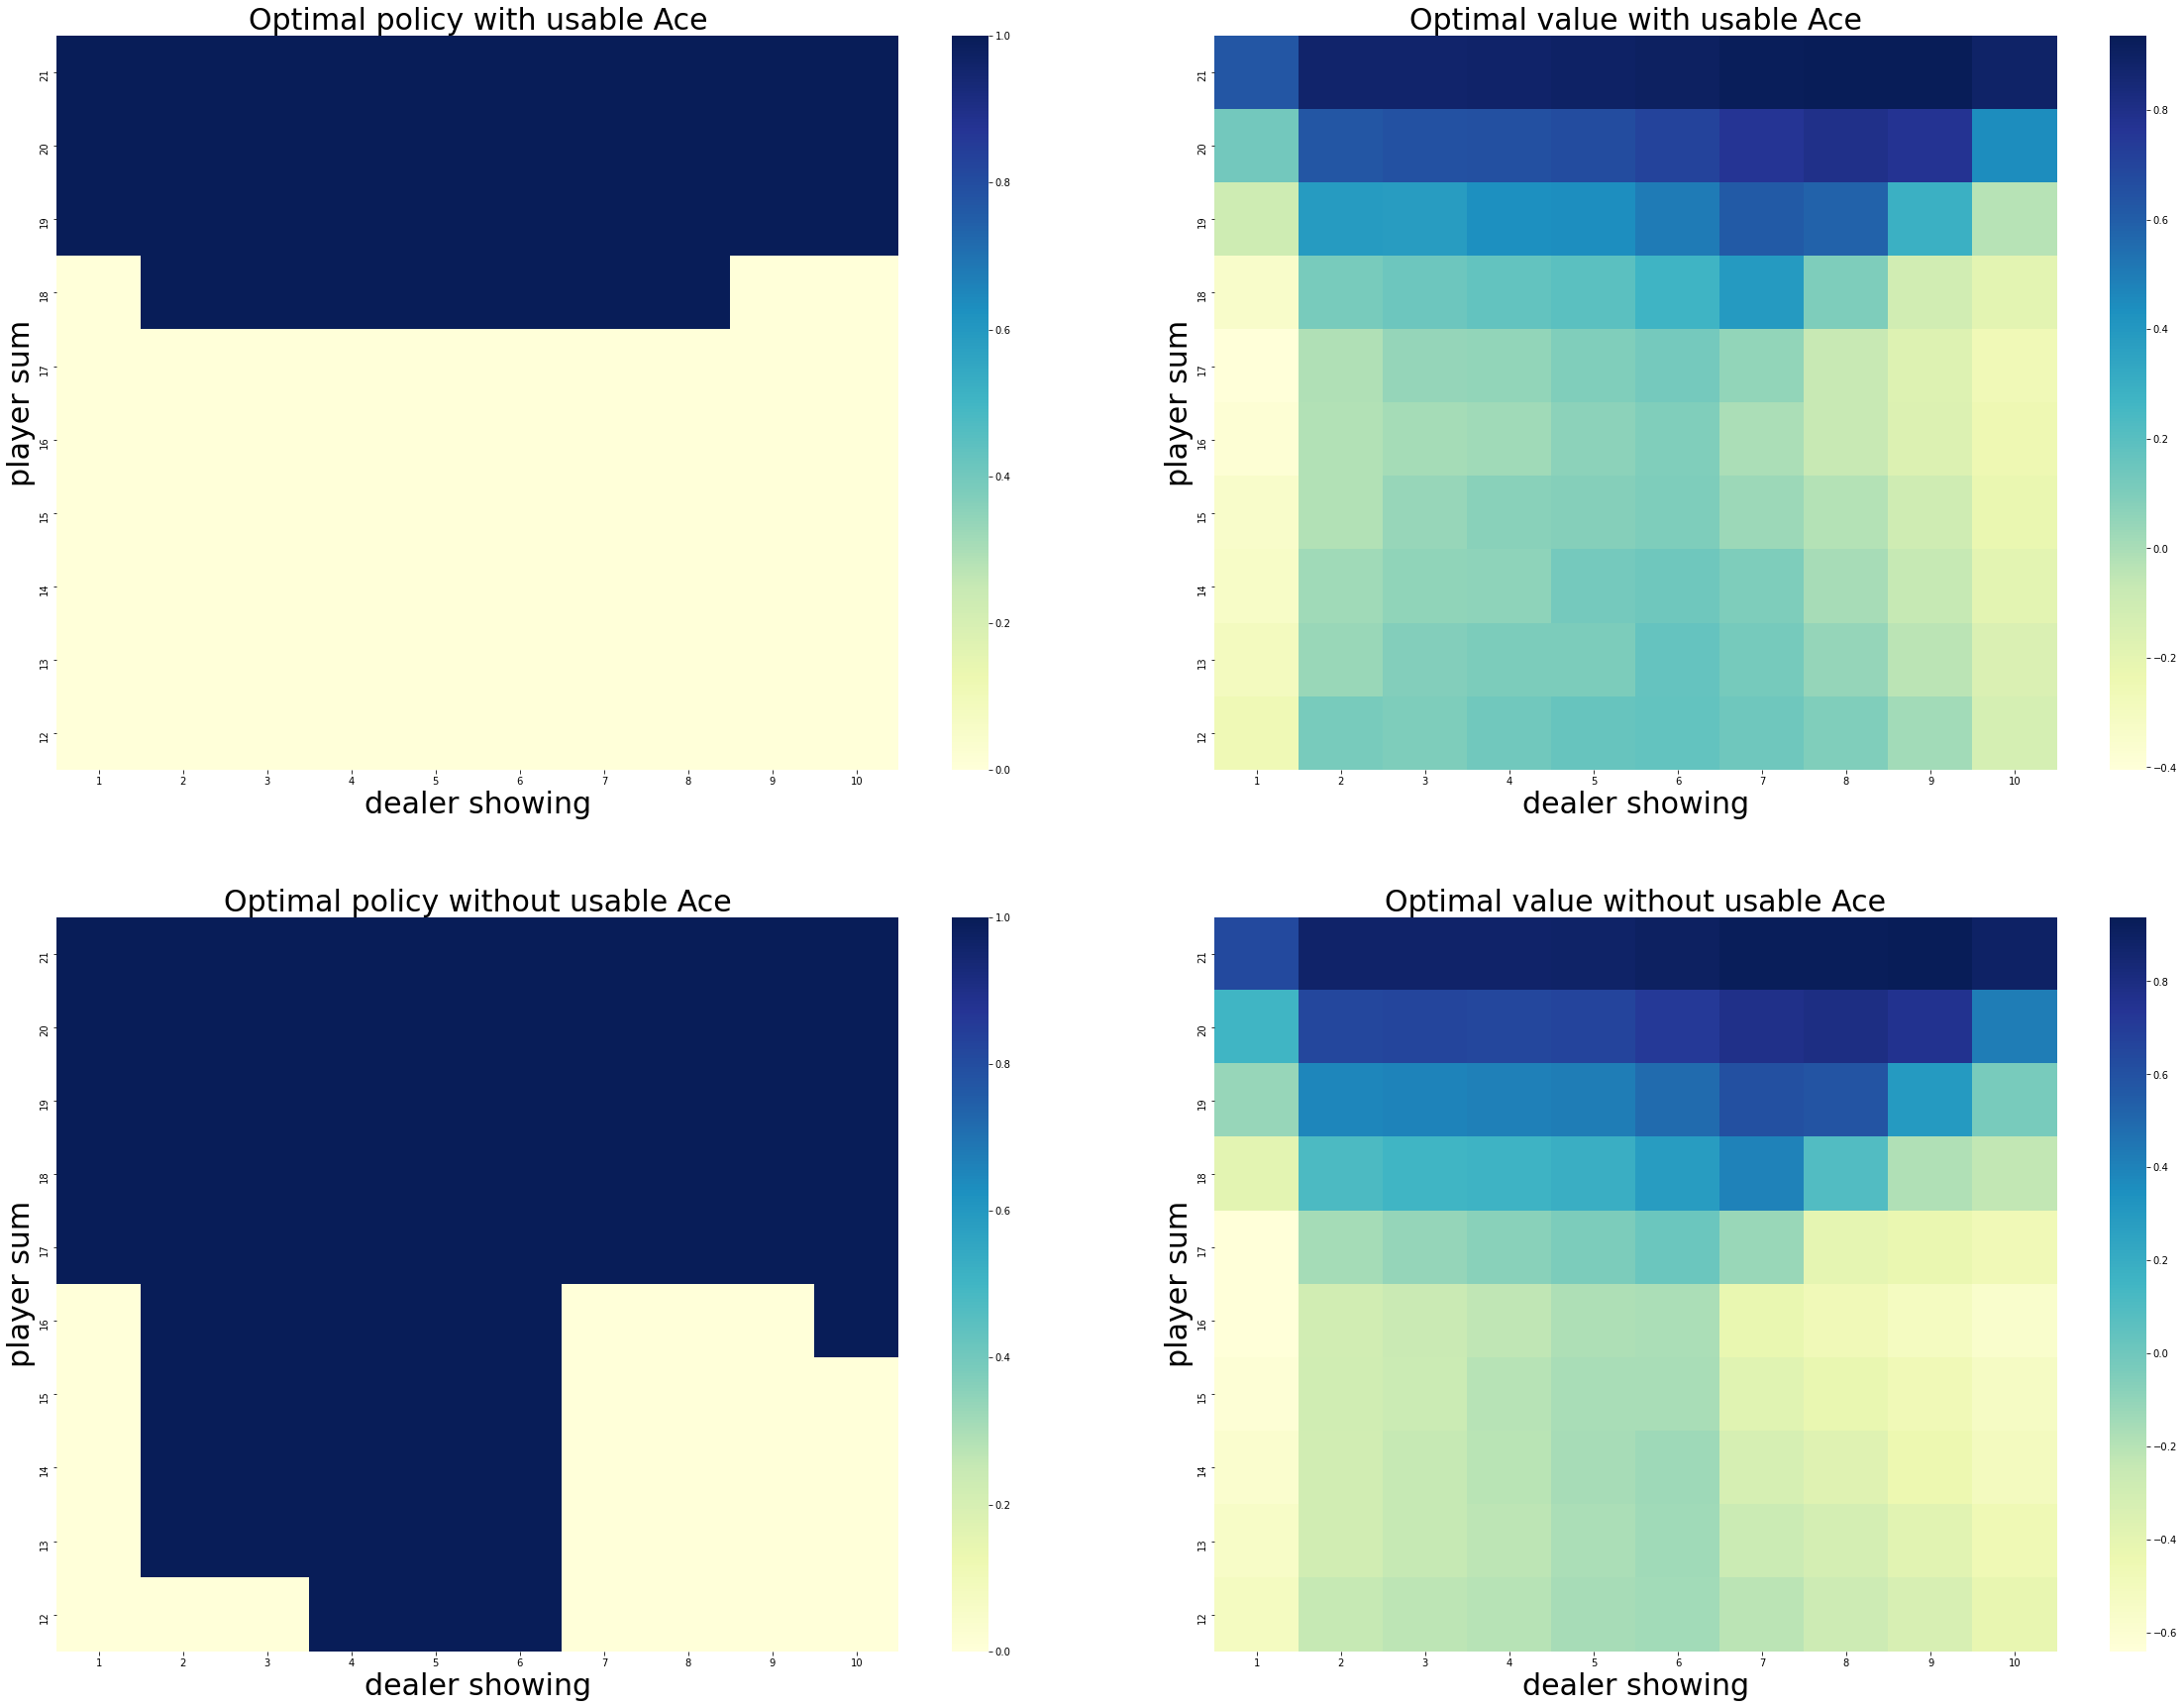

In [40]:
figure_5_2(monte_carlo_exploring_starts,2000000)

In [70]:
def monte_carlo_ε_soft_policies(episodes,ε = 0.1):
    # (playerSum, dealerCard, usableAce, action)
    # (       10,         10,         2,      2)
    state_action_values = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    state_action_pair_count = np.ones((10, 10, 2, 2))
    values = np.zeros((10, 10, 2, 2))
    # greedy policy
    def behavior_policy(usable_ace, player_sum, dealer_card):
        random_num = np.random.binomial(1, ε, 1)
        if random_num == 0:
            usable_ace = int(usable_ace)
            player_sum -= 12
            dealer_card -= 1
            action_values = values[player_sum, dealer_card, usable_ace, :]

            return np.random.choice([action_ for action_, value_ in enumerate( action_values) 
                                     if value_ == np.max(action_values)])
        else:
            # ε的機率隨機選取策略
            return np.random.choice(ACTIONS)
        
    for i in tqdm(range(episodes)):
        #跑過所有state可能
        for state_ace in range(2):
            for state_player in range(12,22):
                for state_dealer in range(1,11):
                    _, reward, trajectory = play(behavior_policy,[state_ace,state_player,state_dealer])
                    # set:一個無序不重複的元素集
                    first_visit_check = set()
                    for (usable_ace, player_sum, dealer_card), action in trajectory:
                        usable_ace = int(usable_ace)
                        player_sum -= 12
                        dealer_card -= 1
                        state_action = (usable_ace, player_sum, dealer_card, action)
                        if state_action in first_visit_check:
                            #避免一局遊戲裡，兩個相同的state重複計算reward
                            #雖然我覺得一局遊戲裡，根本不會有兩個相同的state
                            continue
                        first_visit_check.add(state_action)
                        # update values of state-action pairs
                        state_action_values[player_sum, dealer_card, usable_ace, action] += reward
                        state_action_pair_count[player_sum, dealer_card, usable_ace, action] += 1
                    #update Q(s,a)
                    values = state_action_values / state_action_pair_count
    return values
        

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:54<00:00, 57.37it/s]


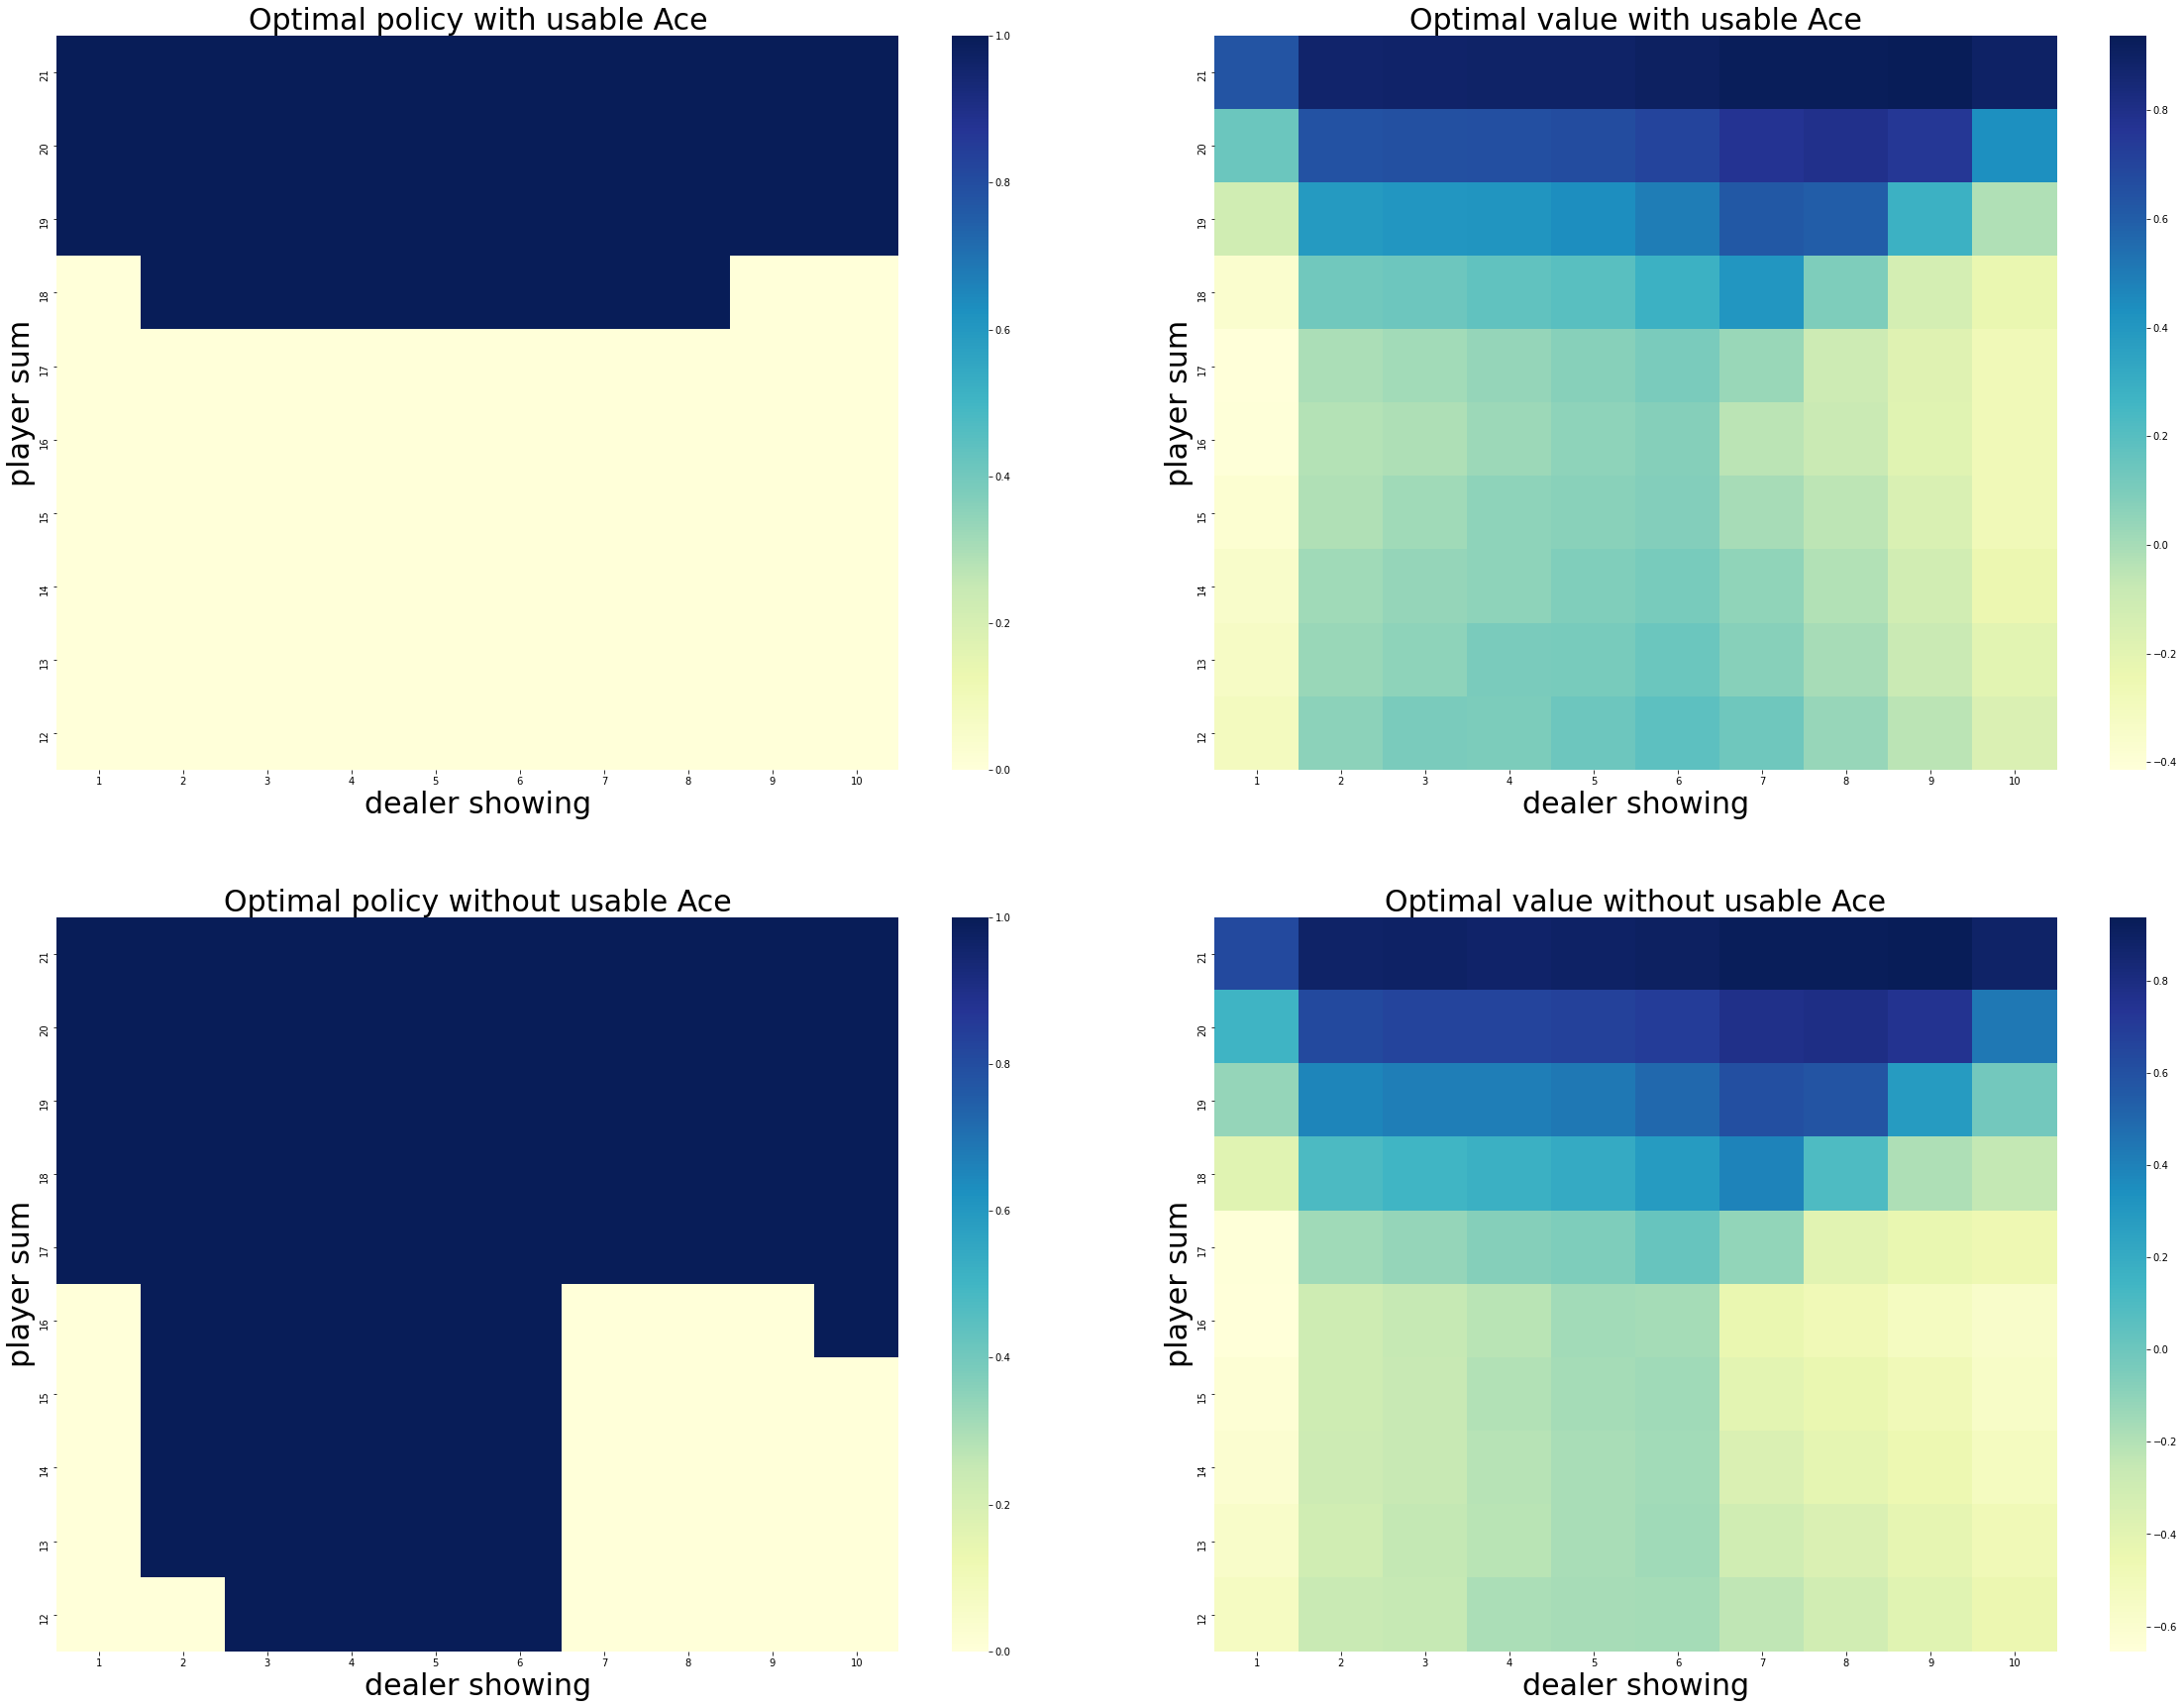

In [71]:
figure_5_2(monte_carlo_ε_soft_policies,10000)

In [77]:
def monte_carlo_off_policy_prediction(episodes):
    values_usable_ace = np.zeros((10, 10))
    values_no_usable_ace = np.ones((10, 10))
    for state_ace in range(2):
        for state_player in range(12,22):
            for state_dealer in range(1,11):
                rhos = []
                returns = []
                for i in range(episodes):
                    _, reward, player_trajectory = play(behavior_policy_player,
                                                         [state_ace,state_player,state_dealer])
                    numerator = 1.0
                    denominator = 1.0
                    for (usable_ace, player_sum, dealer_card), action in player_trajectory:
                        if action == target_policy_player(usable_ace, player_sum, dealer_card):
                            #behavior_policy 隨機，機率為0.5
                            denominator *= 0.5
                        else:
                            #如果behavior_policy之action不等於target_policy_player
                            #機率=0，反之機率等於1
                            numerator = 0.0
                            break
                    rho = numerator / denominator
                    rhos.append(rho)
                    returns.append(reward)
                rhos = np.array(rhos)
                returns = np.array(returns)
                weighted_returns = np.sum(rhos * returns)
                if state_ace == 1:
                    values_usable_ace[state_player - 12, state_dealer - 1] = weighted_returns / episodes
                else:
                    values_no_usable_ace[state_player - 12, state_dealer - 1] = weighted_returns / episodes
    return values_usable_ace,values_no_usable_ace    

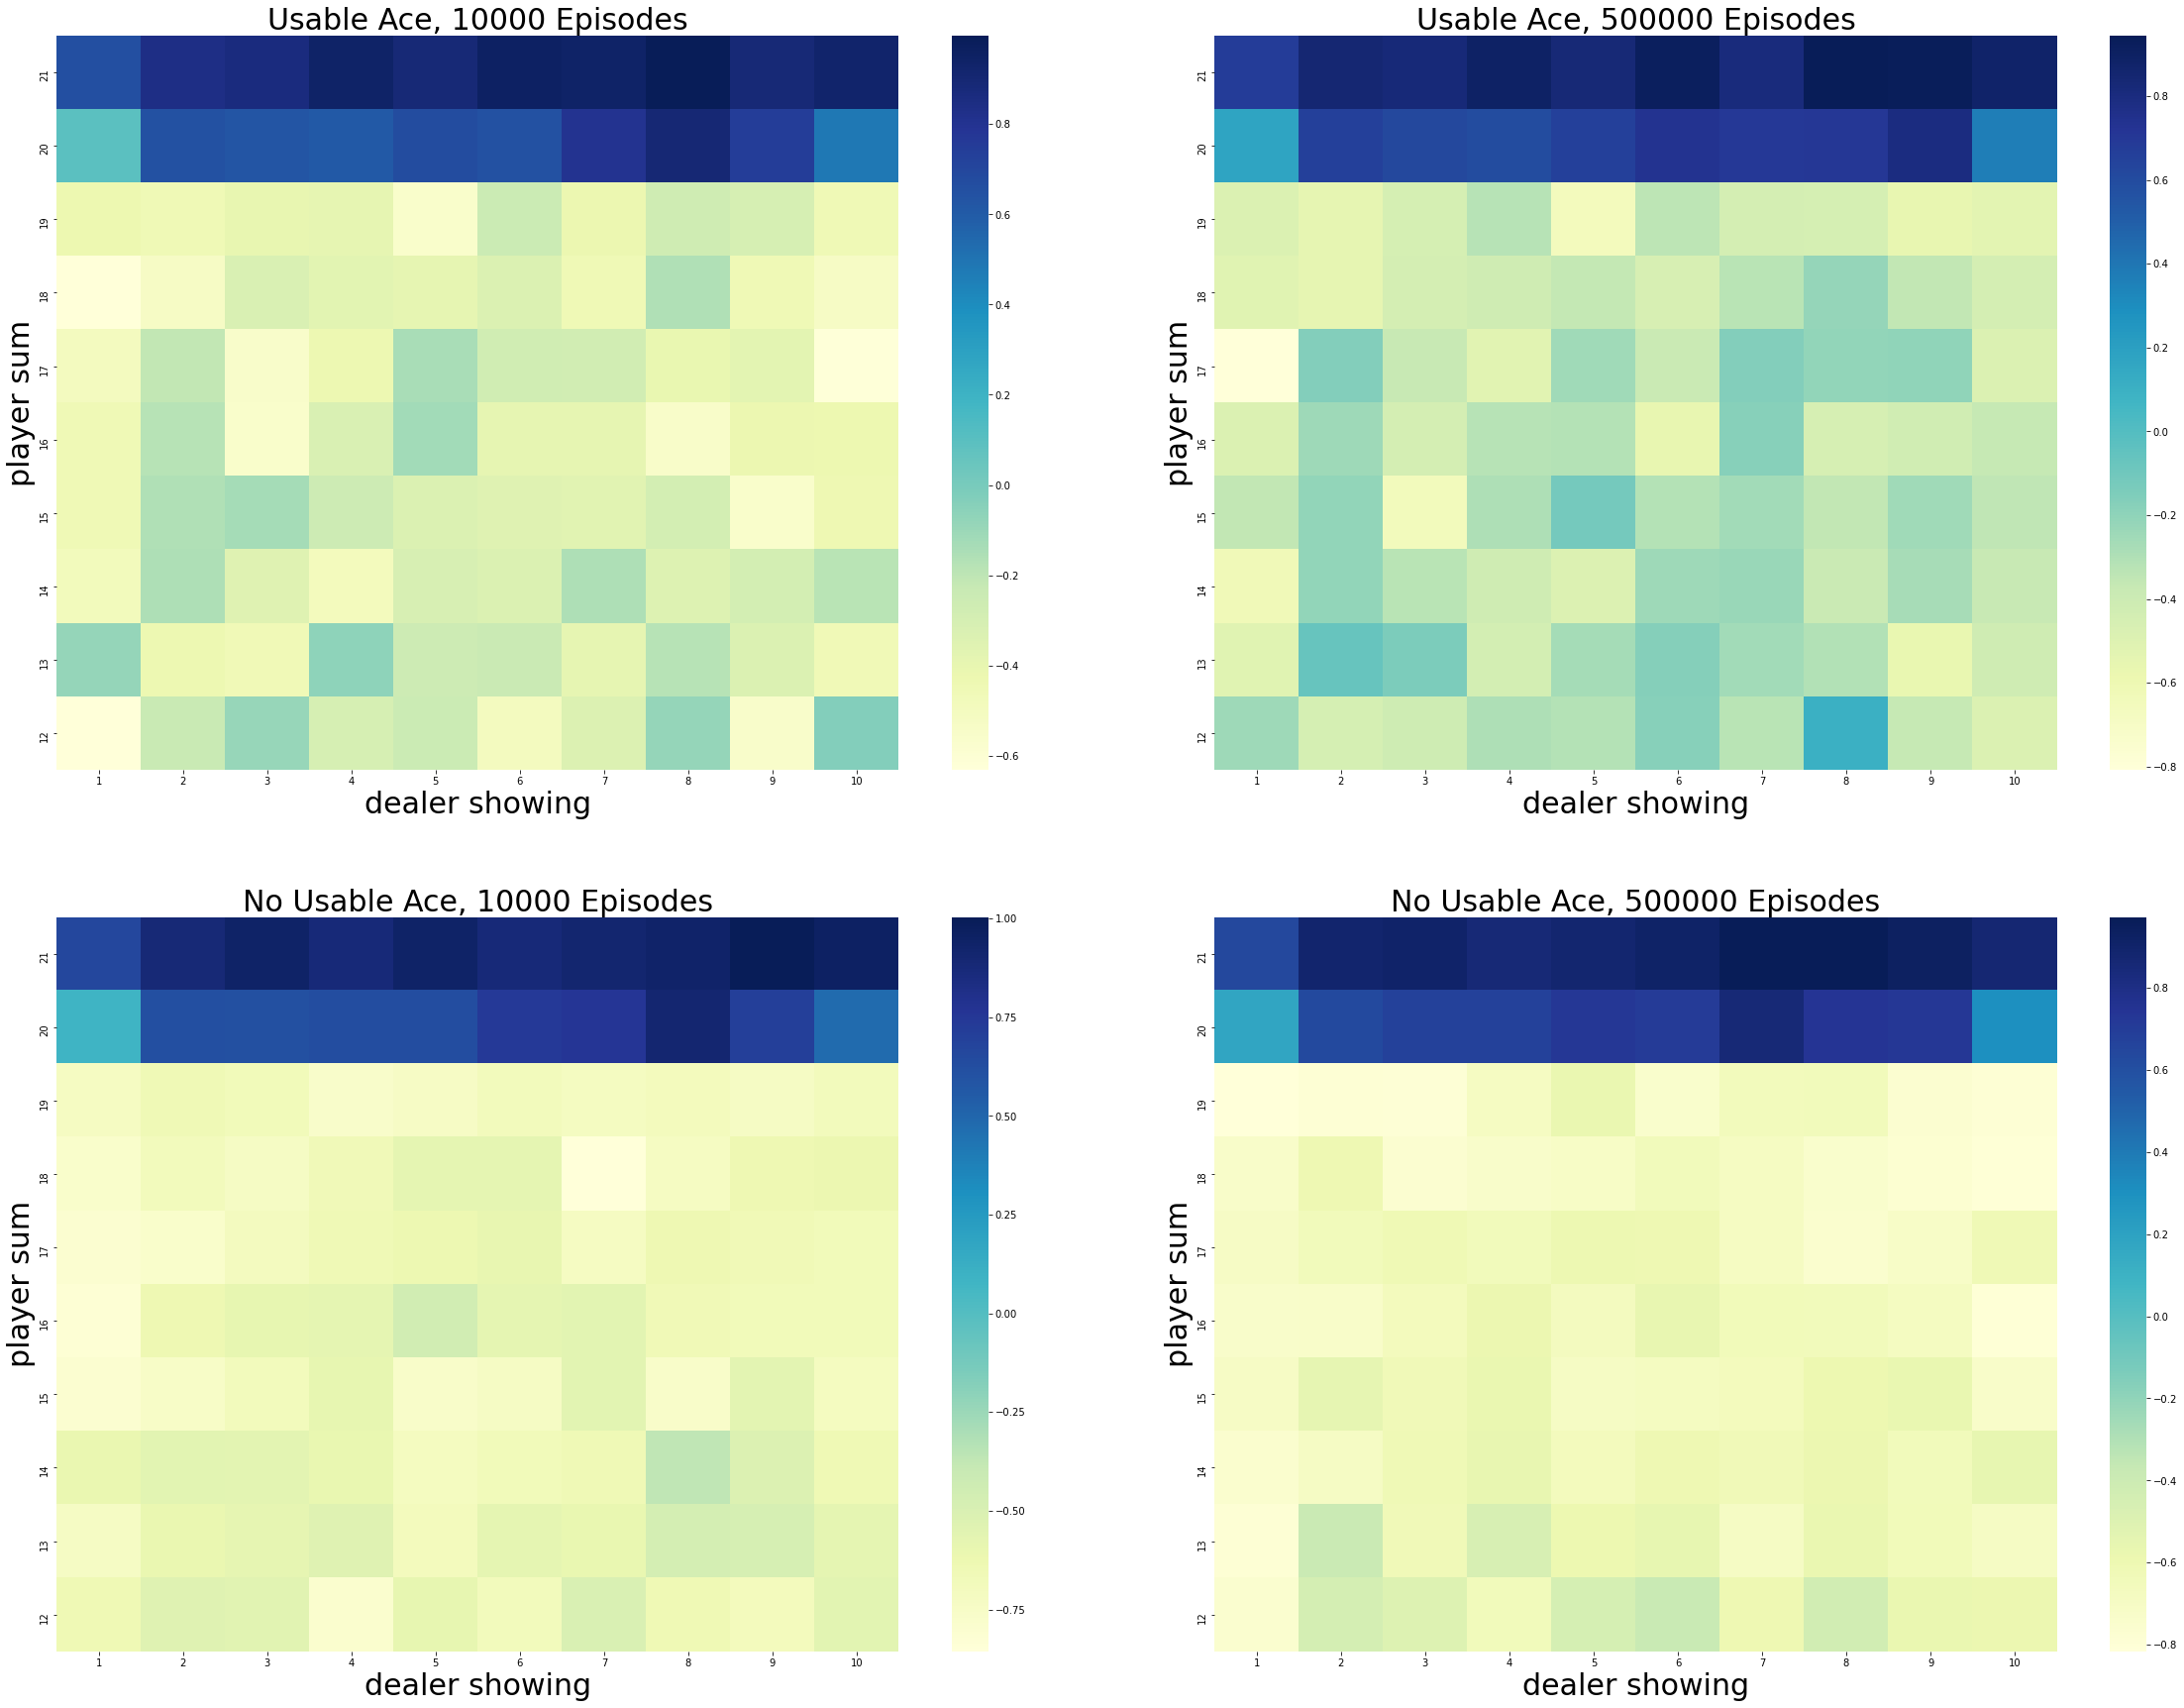

In [80]:
figure_5_1(monte_carlo_off_policy_prediction,500,1000)